In [1]:
import feat_ops
import dataset_utils
import platform_details
import audio_utils
import svm_classifier
import numpy as np
import all_scale
from Viewpoints import Viewpoints

def getTrainData(ragaIds, feature='chroma', size=999999):
    xs = []
    ys = []

    std_size = size
    for id in  ragaIds:
        x = feat_ops.get_merged_genre_feats(id, feature)
        y = np.ones(x.shape[0]) * id
        if(std_size > y.shape[0]):
            std_size = y.shape[0]
        xs.append(x)
        ys.append(y)

    Xs = []
    Ys = []
    for x, y in zip(xs, ys):
        num_elements = np.random.choice(np.arange(y.shape[0]), std_size)
        X = x[num_elements]
        Y = y[num_elements]
        Xs.append(X)
        Ys.append(Y)
    retX = Xs[0]
    retY = Ys[0]
    for i in range(1, len(Ys)):
        retX = np.append(retX, Xs[i], axis=0)
        retY = np.append(retY, Ys[i], axis=0)

    return retX, retY

def flattenX(X):
    _x = []
    for x in X:
        _x.append(x.ravel())
    return np.array(_x)

def gated_selection_X(X):
    _x = []
    for x in X:
        add_x = audio_utils._add_rests(x)
        add_x = audio_utils.gated_selection(add_x)
        _x.append(add_x)
    return np.array(_x)

def get_pitches_data(X):
    new_X = []
    new_size = 0
    pitches = []
    for chroma in X:
        vp = Viewpoints(chroma)
        pitch = vp.get_pitches()
        if pitch.shape[0] > new_size:
            new_size = pitch.shape[0]
        pitches.append(pitch)
    return pitches

def get_pcd_data(X, version='bigram'):
    pcds = []
    for chroma in X:
        vp = Viewpoints(chroma)
        events, dists = vp.scale_sensitive_params()
        pcd = dists[1] if version=='weighted' else dists[0]
        if version == 'bigram':
            pcd = vp.get_viewpoint('bigram_pcd')
        pcds.append(pcd)
    return np.array(pcds)

def standardise_note_events(array, size):
    new_arr = []
    for p in array:
        if p.shape[0] < size:
            p = np.append(p, np.zeros(size - p.shape[0]), axis=0)
        new_arr.append(p)
    return np.array(new_arr)

def normalize_pitchData_X(X):
    Xmax = 0
    Xmin = 9999
    for x in X:
        if Xmax < max(x):
            Xmax = max(x)
        if Xmin > min(x):
            Xmin = min(x)

    if Xmin == 0:
        for i in range(len(X)):
            X[i] += 1
    for i in range(len(X)):
        X[i] = X[i] / Xmax
    return X

In [28]:
X, y = getTrainData((3, 41))
X = gated_selection_X(X)
FEATURE_SET_SIZE = 1500
# X = standardise_note_events(X, FEATURE_SET_SIZE)
# X = flattenX(X)
print(X.shape, y.shape)

(92, 13, 2585) (92,)


Training the data

In [32]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
import tqdm

clf = svm.SVC(kernel='linear')
X_train, X_test, y_train, y_test = all_scale.train_test_split(X, y, type='events') # train_test_split(X, y, test_size=0.1, shuffle=True)
print("10-fold cross-validation started")
prec = np.zeros(10)
f1 = np.zeros(10)
acc = np.zeros(10)
print("Prec \t F1 \t Acc")
for iter in tqdm.tqdm(range(10)):
    clfX_train = X_train.copy()
    # clfX_train = get_pcd_data(clfX_train, 'bigram')
    clfX_train = flattenX(clfX_train)
    clfX_test = X_test.copy()
    # clfX_test = get_pcd_data(clfX_test, 'bigram')
    clfX_test = flattenX(clfX_test)
    print(clfX_train.shape,clfX_test.shape)
    # clfX_test = standardise_note_events(clfX_test, FEATURE_SET_SIZE)
    clf.fit(clfX_train, y_train)
    predicted = clf.predict(clfX_test)
    p = metrics.precision_score(y_test, predicted, pos_label=y[0])
    prec[iter] = p
    f = metrics.f1_score(y_test, predicted, pos_label=y[0])
    f1[iter] = f
    a = metrics.accuracy_score(y_test, predicted)
    acc[iter] = a
    print(f"{p} \t {f} \t {a}")
    X_train, X_test, y_train, y_test = all_scale.train_test_split(X, y, type='events') # train_test_split(X, y, test_size=0.1, shuffle=True)

avg_prec = prec.sum()/len(prec)
avg_f1 = f1.sum() / len(f1)
avg_acc = acc.sum()/len(acc)

print(avg_f1)

100%|██████████| 10/10 [07:06<00:00, 42.66s/it]


10-fold cross-validation started
Prec 	 F1 	 Acc
(984, 33605) (10, 33605)
0.8333333333333334 	 0.9090909090909091 	 0.9
(984, 33605) (10, 33605)
1.0 	 1.0 	 1.0
(984, 33605) (10, 33605)
1.0 	 0.888888888888889 	 0.9
(984, 33605) (10, 33605)
0.8333333333333334 	 0.9090909090909091 	 0.9
(984, 33605) (10, 33605)
0.8 	 0.8000000000000002 	 0.8
(984, 33605) (10, 33605)
1.0 	 0.888888888888889 	 0.9
(984, 33605) (10, 33605)
0.8333333333333334 	 0.9090909090909091 	 0.9
(984, 33605) (10, 33605)
1.0 	 0.888888888888889 	 0.9
(984, 33605) (10, 33605)
1.0 	 0.888888888888889 	 0.9
(984, 33605) (10, 33605)
0.8 	 0.8000000000000002 	 0.8
0.8882828282828283


Testing

In [30]:
test_X, test_y = getTrainData((42, ), size=18)
test_y = (test_y / 42) * 41
test_X = gated_selection_X(test_X)
# test_X = get_pcd_data(test_X, 'bigram')
test_X = flattenX(test_X)
print(test_X.shape, test_y.shape)

(18, 33605) (18,)


    Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Classification report for thee classifier: SVC(kernel='linear')
               precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         0
        41.0       1.00      0.72      0.84        18

    accuracy                           0.72        18
   macro avg       0.50      0.36      0.42        18
weighted avg       1.00      0.72      0.84        18
 



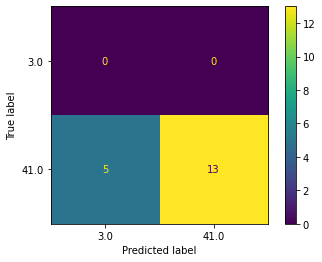

In [33]:
predicted = clf.predict(test_X)

print("Classification report for thee classifier: %s\n %s \n" %
      (clf, metrics.classification_report(test_y, predicted)))

disp = metrics.plot_confusion_matrix(clf, test_X, test_y)

With augmentation

In [28]:
import numpy as np
import librosa as lb
freqs = np.linspace(0, 22050, 32, endpoint=False)[1:]

frqbins = 12 * lb.hz_to_octs(freqs, 440)
frqbins = np.concatenate(([frqbins[0] - 1.5*12], frqbins))
binwidthbins = np.concatenate((np.maximum(frqbins[1:] - frqbins[:-1], 1.0), [1]))
# binwidthbins
# frqbins[1:] - frqbins[:-1]

D = np.subtract.outer(frqbins, np.arange(0, 12, dtype='d')).T
D = np.remainder(D + 6 + 120, 12)
# D + 6 + 120

array([[11.76557586,  5.76557586,  5.76557586,  0.78512587,  5.76557586,
         9.628713  ,  0.78512587,  3.45383493,  5.76557586,  7.80467588,
         9.628713  , 11.27875529,  0.78512587,  2.17085248,  3.45383493,
         4.64826301,  5.76557586,  6.81512996,  7.80467588,  8.74070602,
         9.628713  , 10.47338494, 11.27875529,  0.04831933,  0.78512587,
         1.49185014,  2.17085248,  2.82422589,  3.45383493,  4.0613478 ,
         4.64826301,  5.21593159],
       [10.76557586,  4.76557586,  4.76557586, 11.78512587,  4.76557586,
         8.628713  , 11.78512587,  2.45383493,  4.76557586,  6.80467588,
         8.628713  , 10.27875529, 11.78512587,  1.17085248,  2.45383493,
         3.64826301,  4.76557586,  5.81512996,  6.80467588,  7.74070602,
         8.628713  ,  9.47338494, 10.27875529, 11.04831933, 11.78512587,
         0.49185014,  1.17085248,  1.82422589,  2.45383493,  3.0613478 ,
         3.64826301,  4.21593159],
       [ 9.76557586,  3.76557586,  3.76557586, 10.7851

In [1]:
import librosa
import numpy as np

y, sr = librosa.load(r"C:\Users\theko\Documents\Yaman\Audio\Gat1-000.wav", sr=44100)

In [14]:
n_octaves = int(np.ceil(float(36) / 12))
n_filters = 12

len_orig = len(y)
fmin = librosa.note_to_hz("C3")
tuning = librosa.estimate_tuning(y=y, sr=sr)

freqs = librosa.cqt_frequencies(36, fmin, bins_per_octave=12)[-12:]

fmin_t = np.min(freqs)
fmax_t = np.max(freqs)

Q = 1.0 / (2.0**( 1. / 12.0) - 1)
filter_cutoff = fmax_t * (1 + 0.5 * librosa.filters.window_bandwidth('hann') / Q)
nyquist_frq = sr / 2.0
print(filter_cutoff, librosa.audio.BW_FASTEST * nyquist_frq)

1031.8237239400162 18742.5
